In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/benjaminrike1/social_score_csr_reports.git

Cloning into 'social_score_csr_reports'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 259 (delta 14), reused 43 (delta 13), pack-reused 215
Receiving objects: 100% (259/259), 786.58 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Checking out files: 100% (79/79), done.


In [4]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 11.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [65]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

In [66]:
data_path = ''
social_scores = pd.read_csv(data_path+'social_scores.csv', index_col=0)

In [67]:
# reading in company-ticker mapping
df_financial = pd.read_csv('Financial_data/Tickers.csv', sep=';')
df_financial = df_financial[(df_financial['Ticker'])!='0'].reset_index(drop=True)
df_financial.head()

,Company,Ticker
0,ABNAMRO,ABN.AS
1,Amazon,AMZN
2,asr,ASRNL.AS
3,bam,BAMNB.AS
4,CocaCola,KO


In [68]:
# merging financial and social_scores df
df_financial = df_financial.merge(social_scores, on='Company')

In [69]:
# downloading company info from Yahoo
information = df_financial['Ticker'].apply(lambda x: yf.Ticker(x).info)
information

0     {'zip': '1082 PP', 'sector': 'Financial Servic...
1     {'zip': '98109-5210', 'sector': 'Consumer Cycl...
2     {'zip': '3584 BA', 'sector': 'Financial Servic...
3     {'zip': '3981 AZ', 'sector': 'Industrials', 'f...
4     {'zip': '30313', 'sector': 'Consumer Defensive...
5     {'zip': 'NW1 3AX', 'sector': 'Consumer Cyclica...
6     {'zip': '101 23', 'sector': 'Consumer Defensiv...
7     {'zip': '94025', 'sector': 'Communication Serv...
8     {'zip': '6340', 'sector': 'Industrials', 'full...
9     {'zip': '94043', 'sector': 'Communication Serv...
10    {'zip': '1017 ZD', 'sector': 'Consumer Defensi...
11    {'zip': '40589', 'sector': 'Consumer Defensive...
12    {'zip': '94304', 'sector': 'Technology', 'full...
13    {'zip': '1102 CT', 'sector': 'Financial Servic...
14    {'zip': '95054-1549', 'sector': 'Technology', ...
15    {'zip': '3072 AP', 'sector': 'Communication Se...
16    {'zip': '98052-6399', 'sector': 'Technology', ...
17    {'zip': '2595 AS', 'sector': 'Financial Se

In [70]:
df_financial.head()

,Company,Ticker,scores
0,ABNAMRO,ABN.AS,0.253972
1,Amazon,AMZN,0.322418
2,asr,ASRNL.AS,0.280407
3,bam,BAMNB.AS,0.381486
4,CocaCola,KO,0.317769


In [71]:
# extracting sector, exchange and currency as features
df_financial['sector'] = [x.get('sector') for x in information]
df_financial['exchange'] = [x.get('exchange') for x in information]
df_financial['currency'] = [x.get('currency') for x in information]
df_financial['employees'] = [x.get('fullTimeEmployees') for x in information]
df_financial['country'] = [x.get('country') for x in information]
df_financial['ebitdaMargins'] = [x.get('ebitdaMargins') for x in information]
df_financial['ebitda'] = [x.get('ebitda') for x in information]
df_financial['Beta'] = [x.get('beta') for x in information]


# Disse trenger vi vel ikke nå?
#df_financial['totalRevenue'] = [x.get('totalRevenue') for x in information]
#df_financial['enterpriseValue'] = [x.get('enterpriseValue') for x in information]
#df_financial['marketCap'] = [x.get('marketCap') for x in information]
#df_financial['revenueGrowth'] = [x.get('revenueGrowth') for x in information]

In [72]:
#Adding Total Revenue and Market cap for each year
manual_data = pd.read_csv('Financial_data/Manual_finance_data.csv', sep=';')

df_financial = df_financial.merge(manual_data, on='Company')
df_financial.head()

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,ebitda,...,Total_revenue_2018,Total_revenue_2019,Total_revenue_2020,Total_revenue_2021,Market_cap_2017,Market_cap_2018,Market_cap_2019,Market_cap_2020,Market_cap_2021,Market_cap_2022
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,NaN,...,8976000,8419000,7517000,7343000,19787,25286,19307,15246,7538,12141
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11606,5.544900e+10,...,232887000,280522000,386064000,469822000,356315,563535,734416,916153,1634168,1691002
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,1.490300e+09,...,5685000,7986000,7510000,9824000,3390,5043,4876,4704,4548,5270
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,1.349100e+08,...,7207751,7209089,6768171,7315281,1188,1047,697,734,466,735
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33198,1.332100e+10,...,34300000,37266000,33014000,38655000,175815,195479,201546,237147,235671,255753


In [74]:

#Using dictionary to map currency to the Yahoo searchword for exchange rate
Valuta = {'EUR': 'EURUSD=x', 'DKK': 'DKKUSD=x', 'SEK': 'SEKUSD=x', 'CHF':'CHFUSD=x' ,
 'GBp':'GBPUSD=x', 'USD': 'USD=x'}
df_financial['valuta_ticker'] = df_financial['currency'].map(Valuta)

# Correcting for exchange rates for stock and stock exchange prices
df_financial['Exchange_rate_2017'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2017-01-01', progress=False).Close[0])
df_financial['Exchange_rate_2018'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2018-01-01', progress=False).Close[0])
df_financial['Exchange_rate_2019'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2019-01-01', progress=False).Close[0])
df_financial['Exchange_rate_2020'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2020-01-01', progress=False).Close[0])
df_financial['Exchange_rate_2021'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2021-01-01', progress=False).Close[0])
df_financial['Exchange_rate_2022'] = df_financial['valuta_ticker'].apply(lambda x: yf.download(x, '2022-01-01', progress=False).Close[0])


#Converting all numbers to USD
df_financial['Total_revenue_2016'] = df_financial['Total_revenue_2016']*df_financial['Exchange_rate_2017']
df_financial['Total_revenue_2017'] = df_financial['Total_revenue_2017']*df_financial['Exchange_rate_2018']
df_financial['Total_revenue_2018'] = df_financial['Total_revenue_2018']*df_financial['Exchange_rate_2019']
df_financial['Total_revenue_2019'] = df_financial['Total_revenue_2019']*df_financial['Exchange_rate_2020']
df_financial['Total_revenue_2020'] = df_financial['Total_revenue_2020']*df_financial['Exchange_rate_2021']
df_financial['Total_revenue_2021'] = df_financial['Total_revenue_2021']*df_financial['Exchange_rate_2022']

df_financial['Market_cap_2017'] = df_financial['Market_cap_2017']*df_financial['Exchange_rate_2017']
df_financial['Market_cap_2018'] = df_financial['Market_cap_2018']*df_financial['Exchange_rate_2018']
df_financial['Market_cap_2019'] = df_financial['Market_cap_2019']*df_financial['Exchange_rate_2019']
df_financial['Market_cap_2020'] = df_financial['Market_cap_2020']*df_financial['Exchange_rate_2020']
df_financial['Market_cap_2021'] = df_financial['Market_cap_2021']*df_financial['Exchange_rate_2021']
df_financial['Market_cap_2022'] = df_financial['Market_cap_2022']*df_financial['Exchange_rate_2022']

#Calculating Revnue growth from total revenue
df_financial['Revenue_growth_2017'] = (df_financial['Total_revenue_2017']/df_financial['Total_revenue_2016'])-1
df_financial['Revenue_growth_2018'] = (df_financial['Total_revenue_2018']/df_financial['Total_revenue_2017'])-1
df_financial['Revenue_growth_2019'] = (df_financial['Total_revenue_2019']/df_financial['Total_revenue_2018'])-1
df_financial['Revenue_growth_2020'] = (df_financial['Total_revenue_2020']/df_financial['Total_revenue_2019'])-1
df_financial['Revenue_growth_2021'] = (df_financial['Total_revenue_2021']/df_financial['Total_revenue_2020'])-1

# Calculating average Market cap for each year (Market_Cap_2017 is from 01.01.2017 etc.)
df_financial['Avg_market_cap_2017'] = (df_financial['Market_cap_2017']+df_financial['Market_cap_2018'])/2
df_financial['Avg_market_cap_2018'] = (df_financial['Market_cap_2018']+df_financial['Market_cap_2019'])/2
df_financial['Avg_market_cap_2019'] = (df_financial['Market_cap_2019']+df_financial['Market_cap_2020'])/2
df_financial['Avg_market_cap_2020'] = (df_financial['Market_cap_2020']+df_financial['Market_cap_2021'])/2
df_financial['Avg_market_cap_2021'] = (df_financial['Market_cap_2021']+df_financial['Market_cap_2022'])/2

df_financial.head()

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,ebitda,...,Revenue_growth_2017,Revenue_growth_2018,Revenue_growth_2019,Revenue_growth_2020,Revenue_growth_2021,Avg_market_cap_2017,Avg_market_cap_2018,Avg_market_cap_2019,Avg_market_cap_2020,Avg_market_cap_2021
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,NaN,...,0.298625,-0.079273,-0.081539,-0.019656,-0.100571,25592.721645,26221.405402,19583.062743,1.317534e+04,1.151069e+04
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11606,5.544900e+10,...,12.079633,0.309340,0.204541,0.376234,0.216954,459925.000000,648975.500000,825284.500000,1.275160e+06,1.662585e+06
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,1.490300e+09,...,0.200495,-0.121401,0.375568,0.032536,0.204443,4811.370390,5816.106014,5423.839065,5.431777e+03,5.781141e+03
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,1.349100e+08,...,0.136412,0.040102,-0.020592,0.030826,-0.004829,1253.761569,1027.141055,809.806415,6.977119e+02,7.027824e+02
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33198,1.332100e+10,...,-0.134988,-0.052800,0.086472,-0.114099,0.170867,185647.000000,198512.500000,219346.500000,2.364090e+05,2.457120e+05


In [75]:
# extracting adujsted price for each year
df_financial['adjusted_01.01.2017'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2017-01-01',progress=False)['Adj Close'].values[0])
df_financial['adjusted_01.01.2018'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2018-01-01',progress=False)['Adj Close'].values[0])
df_financial['adjusted_01.01.2019'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2019-01-01',progress=False)['Adj Close'].values[0])
df_financial['adjusted_01.01.2020'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2020-01-01',progress=False)['Adj Close'].values[0])
df_financial['adjusted_01.01.2021'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2021-01-01',progress=False)['Adj Close'].values[0])
df_financial['adjusted_01.01.2022'] = df_financial['Ticker'].apply(lambda x: yf.download(x, '2022-01-01',progress=False)['Adj Close'].values[0])

In [76]:
df_financial

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,ebitda,...,Avg_market_cap_2018,Avg_market_cap_2019,Avg_market_cap_2020,Avg_market_cap_2021,adjusted_01.01.2017,adjusted_01.01.2018,adjusted_01.01.2019,adjusted_01.01.2020,adjusted_01.01.2021,adjusted_01.01.2022
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,NaN,...,26221.405402,19583.062743,1.317534e+04,1.151069e+04,15.024590,19.837980,16.149229,14.033644,7.326843,13.132000
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11606,5.544900e+10,...,648975.500000,825284.500000,1.275160e+06,1.662585e+06,753.669983,1189.010010,1501.969971,1847.839966,3256.929932,3334.340088
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,1.490300e+09,...,5816.106014,5423.839065,5.431777e+03,5.781141e+03,16.581993,26.479250,28.565687,29.668695,31.347408,40.779999
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,1.349100e+08,...,1027.141055,809.806415,6.977119e+02,7.027824e+02,4.101527,3.626109,2.436171,2.726000,1.649000,2.734000
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33198,1.332100e+10,...,198512.500000,219346.500000,2.364090e+05,2.457120e+05,35.514393,39.993099,43.020840,51.882885,53.163948,59.209999
5,DS-Smith,SMDS.L,0.293233,Consumer Cyclical,LSE,GBp,28864,United Kingdom,0.11433,7.373000e+08,...,6556.039335,5992.882217,6.466100e+03,7.014385e+03,329.257477,421.026978,271.815735,365.790588,363.370453,383.799988
6,Essity,ESSITY-B.ST,0.364376,Consumer Defensive,STO,SEK,46000,Sweden,0.14329,1.843300e+10,...,18508.562004,19851.333617,2.270614e+04,2.283419e+04,220.877625,206.300583,199.060013,287.664459,261.109528,294.899994
7,Facebook,FB,0.339286,Communication Services,NMS,USD,77805,United States,0.43496,5.205000e+10,...,444742.000000,481023.000000,6.816805e+05,8.568425e+05,116.860001,181.419998,131.089996,205.250000,273.160004,336.350006
8,Forbo,FORN.SW,0.300072,Industrials,EBS,CHF,5532,Switzerland,0.17480,2.192000e+08,...,2517.832783,2559.374093,2.741524e+03,2.994732e+03,1191.457275,1397.889160,1264.348145,1562.262573,1512.593872,1894.000000
9,Google,GOOG,0.188957,Communication Services,NMS,USD,163906,United States,0.35453,9.584100e+10,...,726461.500000,823205.500000,1.054114e+06,1.553568e+06,786.140015,1065.000000,1035.609985,1337.020020,1751.880005,2893.590088


In [77]:
# adding exchange ticker to extract exchange prices
Ticker_exchange = {'NYQ': '^NYA', 'AMS': '^AEX', 'NMS': '^IXIC', 'LSE':'^FTSE' ,
 'STO':'^OMX', 'PNK':'^AEX','EBS':'^SSMI', 'GER':'^GDAXI', 'CPH':'^OMXC20'}
df_financial['Exchange_ticker'] = df_financial['exchange'].map(Ticker_exchange)
df_financial['Exchange_01.01.2017'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2017-01-01',progress=False).Close.values[0])
df_financial['Exchange_01.01.2018'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2018-01-01',progress=False).Close.values[0])
df_financial['Exchange_01.01.2019'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2019-01-01',progress=False).Close.values[0])
df_financial['Exchange_01.01.2020'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2020-01-01',progress=False).Close.values[0])
df_financial['Exchange_01.01.2021'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2021-01-01',progress=False).Close.values[0])
df_financial['Exchange_01.01.2022'] = df_financial['Exchange_ticker'].apply(lambda x: yf.download(x, '2022-01-01',progress=False).Close.values[0])

In [78]:
df_financial['adjusted_01.01.2017'] = df_financial['Exchange_rate_2017']*df_financial['adjusted_01.01.2017']
df_financial['Exchange_01.01.2017'] = df_financial['Exchange_rate_2017']*df_financial['Exchange_01.01.2017']
df_financial['adjusted_01.01.2018'] = df_financial['Exchange_rate_2018']*df_financial['adjusted_01.01.2018']
df_financial['Exchange_01.01.2018'] = df_financial['Exchange_rate_2018']*df_financial['Exchange_01.01.2018']
df_financial['adjusted_01.01.2019'] = df_financial['Exchange_rate_2019']*df_financial['adjusted_01.01.2019']
df_financial['Exchange_01.01.2019'] = df_financial['Exchange_rate_2019']*df_financial['Exchange_01.01.2019']
df_financial['adjusted_01.01.2020'] = df_financial['Exchange_rate_2020']*df_financial['adjusted_01.01.2020']
df_financial['Exchange_01.01.2020'] = df_financial['Exchange_rate_2020']*df_financial['Exchange_01.01.2020']
df_financial['adjusted_01.01.2021'] = df_financial['Exchange_rate_2021']*df_financial['adjusted_01.01.2021']
df_financial['Exchange_01.01.2021'] = df_financial['Exchange_rate_2021']*df_financial['Exchange_01.01.2021']
df_financial['adjusted_01.01.2022'] = df_financial['Exchange_rate_2022']*df_financial['adjusted_01.01.2022']
df_financial['Exchange_01.01.2022'] = df_financial['Exchange_rate_2022']*df_financial['Exchange_01.01.2022']


df_financial.head()

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,ebitda,...,adjusted_01.01.2020,adjusted_01.01.2021,adjusted_01.01.2022,Exchange_ticker,Exchange_01.01.2017,Exchange_01.01.2018,Exchange_01.01.2019,Exchange_01.01.2020,Exchange_01.01.2021,Exchange_01.01.2022
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,NaN,...,15.720905,9.011941,14.872027,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11606,5.544900e+10,...,1847.839966,3256.929932,3334.340088,^IXIC,5429.080078,7006.899902,6635.279785,8972.599609,12888.280273,15644.969727
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,1.490300e+09,...,33.235754,38.556988,46.183463,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,1.349100e+08,...,3.053746,2.028253,3.096263,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33198,1.332100e+10,...,51.882885,53.163948,59.209999,^NYA,11154.349609,12902.719727,11374.389648,13913.030273,14524.799805,17164.130859


In [80]:
df_financial.to_csv('df_financial.csv')

In [ ]:
df_financial['constant'] = [1 for i in range(df_financial.shape[0])]
df_financial.head()

,Company,Ticker,scores,sector,exchange,currency,employees,country,ebitdaMargins,revenueGrowth,...,valuta_ticker,Exchange_rate_2020,Exchange_rate_2022,USD_adjusted_2020.10.05,USD_adjusted_2022.10.05,USD_Exchange_2020.10.05,USD_Exchange_2022.10.05,return,exchange_return,constant
0,ABNAMRO,ABN.AS,0.253972,Financial Services,AMS,EUR,19957,Netherlands,0.00000,-0.027,...,EURUSD=x,1.083952,1.053219,6.481927,11.695999,564.012799,705.383016,0.804402,0.250651,1
1,Amazon,AMZN,0.322418,Consumer Cyclical,NMS,USD,1622000,United States,0.11658,0.073,...,USD=x,1.000000,1.000000,2409.000000,2177.179932,9192.339844,11623.250000,-0.096231,0.264450,1
2,asr,ASRNL.AS,0.280407,Financial Services,AMS,EUR,4155,Netherlands,0.15340,0.082,...,EURUSD=x,1.083952,1.053219,21.545617,45.130441,564.012799,705.383016,1.094646,0.250651,1
3,bam,BAMNB.AS,0.381486,Industrials,AMS,EUR,15739,Netherlands,0.01844,0.000,...,EURUSD=x,1.083952,1.053219,1.602081,2.529832,564.012799,705.383016,0.579091,0.250651,1
4,CocaCola,KO,0.317769,Consumer Defensive,NYQ,USD,79000,United States,0.33215,0.163,...,USD=x,1.000000,1.000000,42.734627,64.010002,11281.370117,15057.870117,0.497849,0.334755,1


In [ ]:
df_fin = pd.get_dummies(df_financial, columns=['sector'])

In [ ]:
# list of features that should be used
features = ['scores', 'exchange_return', 'constant',
            'sector_Communication Services', 'sector_Consumer Cyclical',
            'sector_Consumer Defensive', 'sector_Financial Services',
            'sector_Healthcare', 'sector_Industrials'
            ]

label = 'return' # label that should be predicted

data = (df_fin[features].to_numpy(), df_fin[label].to_numpy())
res = sm.OLS(data[1], data[0]).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.295
Date:                Sat, 21 May 2022   Prob (F-statistic):              0.313
Time:                        10:00:48   Log-Likelihood:                -25.457
No. Observations:                  25   AIC:                             68.91
Df Residuals:                      16   BIC:                             79.88
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.7950      3.303     -1.149      0.2

In [ ]:
df_financial.columns

Index(['Company', 'Ticker', 'scores', 'sector', 'exchange', 'currency',
       'employees', 'country', 'ebitdaMargins', 'revenueGrowth', 'ebitda',
       'totalRevenue', 'enterpriseValue', 'marketCap', 'adjusted_10.05.2020',
       'adjusted_10.05.2022', 'Exchange_ticker', 'Exchange_2020.05.10',
       'Exchange_2022.05.10', 'valuta_ticker', 'Exchange_rate_2020',
       'Exchange_rate_2022', 'USD_adjusted_2020.10.05',
       'USD_adjusted_2022.10.05', 'USD_Exchange_2020.10.05',
       'USD_Exchange_2022.10.05', 'return', 'exchange_return', 'constant'],
      dtype='object')

In [ ]:
corr_feat = ['return', 'scores','employees','ebitdaMargins','revenueGrowth','ebitda','totalRevenue','enterpriseValue','marketCap']
df_corr = df_financial[corr_feat]

In [ ]:
# correlation plot
corr = df_corr.corr()
corr['scores']

return            -0.235212
scores             1.000000
employees         -0.015891
ebitdaMargins     -0.380768
revenueGrowth     -0.113520
ebitda            -0.505283
totalRevenue      -0.220935
enterpriseValue   -0.543701
marketCap         -0.551208
Name: scores, dtype: float64

<AxesSubplot:>

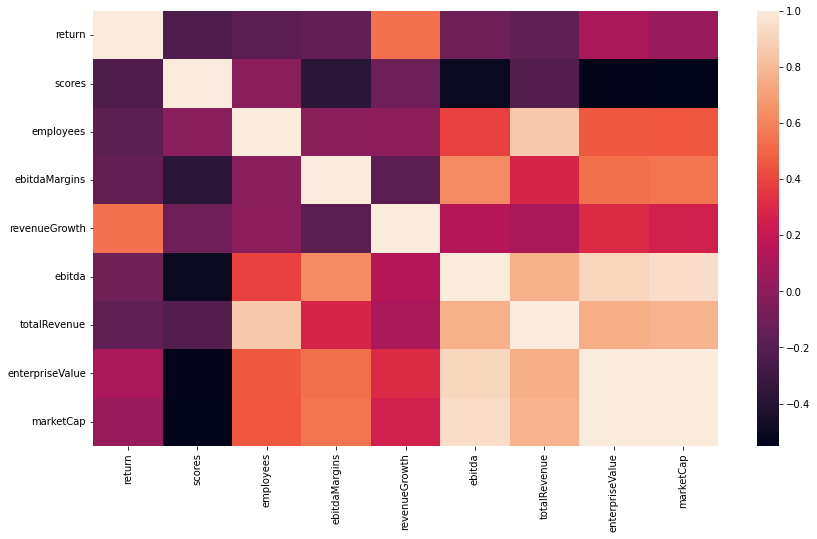

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(corr, ax=ax)